# MD Trajectory Projections using PCA

In [1]:
import pytraj as pyt
import seaborn as sns
sns.set(style='ticks', font_scale = 1.4)
import pandas as pd
import numpy as np
import gc
import sys
from glob import glob
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## CDK2 Atom Masks

In [3]:
from helper_modules.protein_subsequences import get_pisani_residues, \
                get_pocket_residues, get_secondary_structure_residues

# Create the atom selection masks
mask_secnd_strc = '(:' + get_secondary_structure_residues(sep = ',') + ')&(@CA)'
mask_pisani     = '(:' + get_pisani_residues(sep = ',') + ')&(@CA)'
mask_pkt_Ca     = '(:' + get_pocket_residues(sep = ',') + ')&(@CA)'
mask_pkt_noHs   = '(:' + get_pocket_residues(sep = ',') + ')&!(@H=)'

In [4]:
MASK = mask_pkt_noHs

## Reference Structure
- `1fin` structure (with no Hydrogens) will be used as the reference structure to compute the trajectory alignments.

In [5]:
CRYS_DIR = '../../data/crystal_confs/'
ref_top_path = f'{CRYS_DIR}/pdb_modeled/1fin_A_mod.pdb'
ref_conf = pyt.load(ref_top_path, 
                    ref_top_path)
ref_conf

pytraj.Trajectory, 1 frames: 
Size: 0.000054 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

## Crystallographic Ensemble
- Load the crystal structures metadata
- Load the crystal structures as a "trajectory": `crys_traj`

In [6]:
#******************************
# Crystal structures metadata
#******************************
prot_name = 'cdk2'
file = f'../1_Crystal_Structures/df_metadata_{prot_name}_pdbids_LIGS_CONF-LABELS.pkl'
df_prot = pd.read_pickle(file)
# keep only the relevant columns
columns = ['PDB_ID', 'Entities', 'Resolution', 
           'LigPktName', 'LigMW', 'LigNHeavyAtoms', 
           'ConfTypeLabel']
df_prot = df_prot[columns]

#******************************
# Crystal structures "trajectory"
#******************************
CRYS_DIR = '../../data/crystal_confs/'
# Create a crystallographic ensemble (pseudo trajectory)
ENS_CONFS_DIR = f'{CRYS_DIR}/pdb_modeled/'
input_files = sorted(glob(f'{ENS_CONFS_DIR}/*_A_mod.pdb'))

# Make sure that the order of conformations  
# in `input_files` and `pdb_ids` is the same
input_files_basenames = [i.split('/')[-1]\
                         .replace('_A_mod.pdb', '') 
                         for i in input_files]
assert np.all(df_prot['PDB_ID'] == input_files_basenames)

# Reference structure
top_path_crys  = f'{CRYS_DIR}/pdb_modeled/1fin_A_mod.pdb'
# Load the trajectory using pytraj
crys_traj = pyt.iterload(input_files, 
                         top = top_path_crys)
crys_traj

pytraj.TrajectoryIterator, 418 frames: 
Size: 0.022405 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

## Molecular Dynamics Trajectories

- Before performing the analysis `trjconv` was used to strip Hydrogens and keep only protein Heavy Atoms: `md_protein_HvyAtms`

```bash
SELECTION='Protein-H'
# Local path for gromacs
GMX=/Users/joelricci/miniconda/envs/biobb/gromacs-2021.5/bin/gmx 
for d in `ls -d *_systems/*/*/`;
do
echo "$SELECTION" "$SELECTION" | \
    $GMX trjconv \
    -f $d/md/md_imaged_noWAT.trr \
    -s $d/md/md.tpr \
    -o $d/md/md_protein_HvyAtms.trr
done

SELECTION='Protein-H'
# Local path for gromacs
GMX=/Users/joelricci/miniconda/envs/biobb/gromacs-2021.5/bin/gmx 
for d in `ls -d *_systems/*/*/`;
do
echo "$SELECTION" "$SELECTION" | \
    $GMX trjconv \
    -f $d/md/md_imaged_noWAT.trr \
    -s $d/md/md.tpr \
    -o $d/md/md_protein_HvyAtms.pdb \
    -dump 0
done
```

In [7]:
%%time
import itertools as it
import parmed

STRIDE_MD = 5
MD_DIR  = '../../data/md_trajectories/'
SYSTEMS = ['WAT', 'LIG', 'ETA', 'ISO', 'MAM']
PDB_IDS = ['1fin', '4fku', '3pxf', '5a14']
REPS    = [1, 2, 3]
MD_FILE_BASENAME = 'md_protein_HvyAtms'

# List the name of `.trr` files
all_systems = list(it.product(PDB_IDS, SYSTEMS, REPS))
all_systems_md_trr = [f'{MD_DIR}/{system}_systems/rep_{rep}/' +
                      f'{pdb_id}/md/{MD_FILE_BASENAME}.trr'
                      for pdb_id, system, rep in all_systems]

#******************************
#     MD prod trajectories
#******************************
# Use `iterload` to avoid memory issues
top_path  = f'../../data/md_trajectories/WAT_systems/rep_1/1fin/md/md_protein_HvyAtms.gro'
top = pyt.io.load_parmed(parmed.load_file(top_path), traj = False)
md_trajs = pyt.load(all_systems_md_trr, 
                        top = top,
                        frame_indices = range(10, -1),
                        stride = STRIDE_MD)

# Create a dataframe with the label of each MD conformation
# N systems
confs_per_rep = md_trajs.n_frames / len(all_systems)
labels = []
for i in all_systems:
    for j in [i]*int(confs_per_rep):
        labels.append(j)
df_md_projs = pd.DataFrame(labels, 
                columns = ['Conf.', 'MD-Protocol', 'Rep.'])

md_trajs

CPU times: user 8.65 s, sys: 14.7 s, total: 23.4 s
Wall time: 1min 51s


pytraj.Trajectory, 48060 frames: 
Size: 2.575991 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

## MD Projections using PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
type_confs_names  = ['inact_src', 'active', 'inact_ope', 'dfg_out']
refs_conf_type_dict = {'1fin': 'active', '4fku': 'inact_src', 
                       '3pxf': 'inact_ope', '5a14': 'dfg_out'}
ref_confs_colors  = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
conf_label_colors = dict(zip(type_confs_names, ref_confs_colors))

In [10]:
def get_coords(traj, mask, ref_conf, stride = None):
    # traj alingment
    traj = pyt.align(traj, mask = MASK, 
                     ref = ref_conf)[MASK]
    if stride:
        traj = traj[::stride]
    # get coordinates
    traj_coords = traj.xyz
    m, n, c     = traj_coords.shape
    mtx_coords  = traj_coords.reshape((m, n*c)) 
    return mtx_coords

def get_pca_projs(mtx_coords, df_labels, 
                  stride = None, n_components = 2):
    # Perform PCA
    if stride:
        df_labels = df_labels.iloc[::stride]
    pca = PCA(n_components = n_components)
    pca_proj = pca.fit_transform(mtx_coords)
    exp_vars = pca.explained_variance_ratio_ * 100
    x = pca_proj[:,0]
    y = pca_proj[:,1]
    df = df_labels.copy()
    df['x'] = x
    df['y'] = y
    return df, exp_vars, pca

def plot_projection(df, color_hue, plot_title = '',
                    exp_vars = (None, None), 
                    linewidth = 0, ax = None, **kwargs):
    if not ax:
        fig, ax = plt.subplots(figsize = (8,8))
    sns.scatterplot(data = df, 
                         x = 'x', y = 'y', 
                         alpha = 0.5,
                         linewidth = linewidth,
                         hue = color_hue, **kwargs)
    ax.set_title(plot_title)
    ax.set(xlabel = f'PC1 ({exp_vars[0]:.2f}%)', 
           ylabel = f'PC2 ({exp_vars[1]:.2f}%)')
    ax.axvline(0, ls = ':', color = 'gray', lw = 2.5, zorder = -10)
    ax.axhline(0, ls = ':', color = 'gray', lw = 2.5, zorder = -10)
    return ax

def plot_initial_confs(ax, pca, 
                       edgecolor = 'black', 
                       textcolor = 'black',
                       xy_text_displace = (0.3, 0.3),
                       **text_kwargs):
    # Project crystal confs
    init_confs_idx = [input_files_basenames.index(i) 
                      for i in PDB_IDS]
    TRAJ = crys_traj[init_confs_idx]
    sup_coords = get_coords(traj = TRAJ, 
                            mask = MASK, 
                            ref_conf = ref_conf)
    # Use the PCA defined by the MD confs to project
    # the four initial structures
    x, y = pca.transform(sup_coords).T
    sns.scatterplot(
        x = x, y = y,
        linewidth = 2, edgecolor = edgecolor,
        facecolors = 'cyan',ax = ax
    )
    for x, y, conf in zip(x, y, PDB_IDS):
        plt.text(x + xy_text_displace[0], y + xy_text_displace[1], 
                 s = conf, fontweight = 'bold', 
                 c = textcolor, **text_kwargs)

## Crystal Conformations
- Pisani Selection ($\alpha C$)

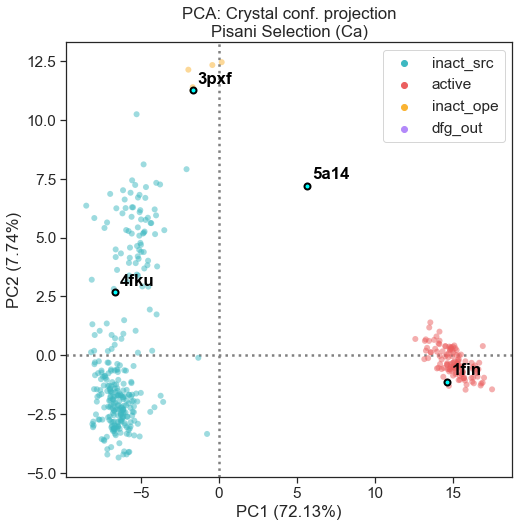

In [11]:
TRAJ    = crys_traj
MASK    = mask_pisani
STRIDE  = 1
COL_HUE = 'ConfTypeLabel'
DF_PLOT = df_prot[['PDB_ID', COL_HUE]]
PLOT_TITLE = 'PCA: Crystal conf. projection\nPisani Selection (Ca)'

mtx_coords = get_coords(traj = crys_traj, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     palette = conf_label_colors)
# Project reference confs
plot_initial_confs(ax, pca)

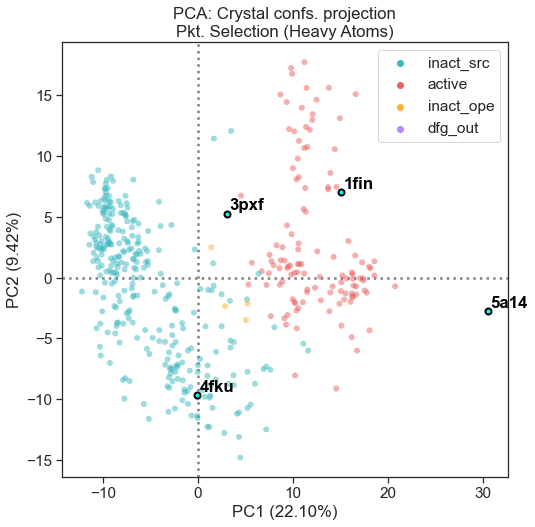

In [12]:
TRAJ    = crys_traj
MASK    = mask_pkt_noHs
STRIDE  = 1
COL_HUE = 'ConfTypeLabel'
DF_PLOT = df_prot[['PDB_ID', COL_HUE]]
PLOT_TITLE = 'PCA: Crystal confs. projection\nPkt. Selection (Heavy Atoms)'

mtx_coords = get_coords(traj = crys_traj, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     palette = conf_label_colors)
# Project reference confs
plot_initial_confs(ax, pca)

In [13]:
import pylab as plot
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plot.rcParams.update(params)

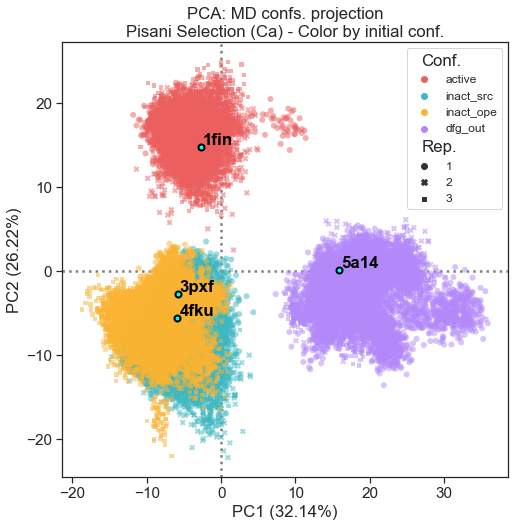

In [14]:
TRAJ    = md_trajs
MASK    = mask_pisani
STRIDE  = 1 # STRIDE_MD * STRIDE
COL_HUE = 'Conf.'
DF_PLOT = df_md_projs.replace(refs_conf_type_dict)
PLOT_TITLE = 'PCA: MD confs. projection\nPisani Selection (Ca)' +\
             ' - Color by initial conf.'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'Rep.',
                     palette = conf_label_colors)

# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax, pca)

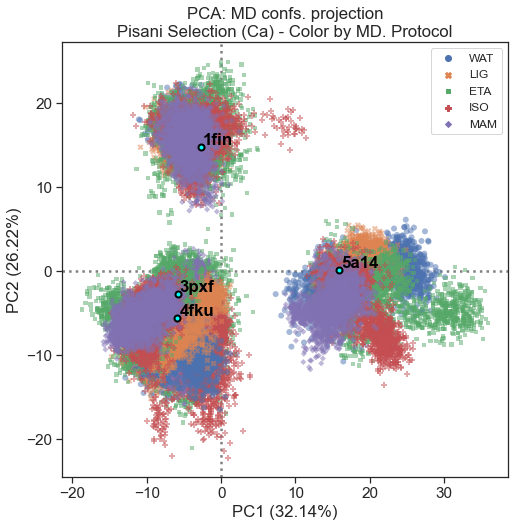

In [15]:
TRAJ    = md_trajs
MASK    = mask_pisani
STRIDE  = 1 # STRIDE_MD * STRIDE
COL_HUE = 'MD-Protocol'
DF_PLOT = df_md_projs.replace(refs_conf_type_dict)
PLOT_TITLE = 'PCA: MD confs. projection\nPisani Selection (Ca)' +\
             ' - Color by MD. Protocol'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol'
                    )

# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax, pca)

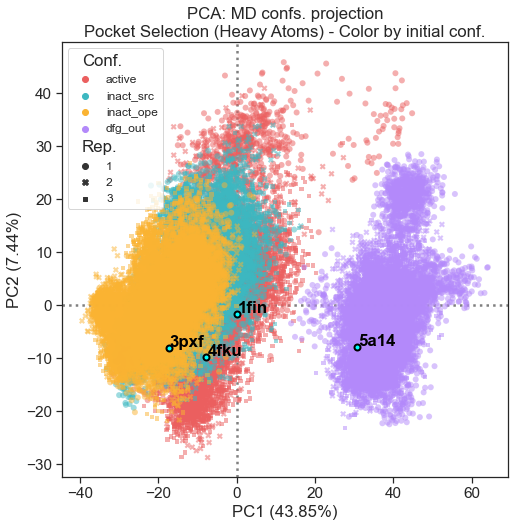

In [16]:
TRAJ    = md_trajs
MASK    = mask_pkt_noHs
STRIDE  = 1 # STRIDE_MD * STRIDE
COL_HUE = 'Conf.'
DF_PLOT = df_md_projs.replace(refs_conf_type_dict)
PLOT_TITLE = 'PCA: MD confs. projection\nPocket Selection (Heavy Atoms)'  +\
             ' - Color by initial conf.'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'Rep.',
                     palette = conf_label_colors)

# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax, pca)

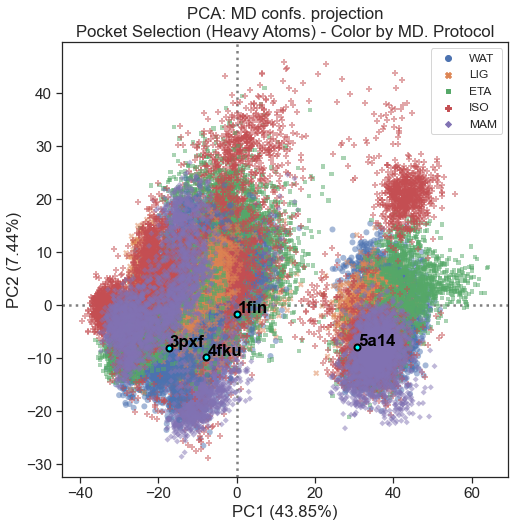

In [17]:
TRAJ    = md_trajs
MASK    = mask_pkt_noHs
STRIDE  = 1 # STRIDE_MD * STRIDE
COL_HUE = 'MD-Protocol'
DF_PLOT = df_md_projs.replace(refs_conf_type_dict)
PLOT_TITLE = 'PCA: MD confs. projection\nPocket Selection (Heavy Atoms)'  +\
             ' - Color by MD. Protocol'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol')

# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax, pca)

## Concatenate Crys and MD conformations in a single trajectory

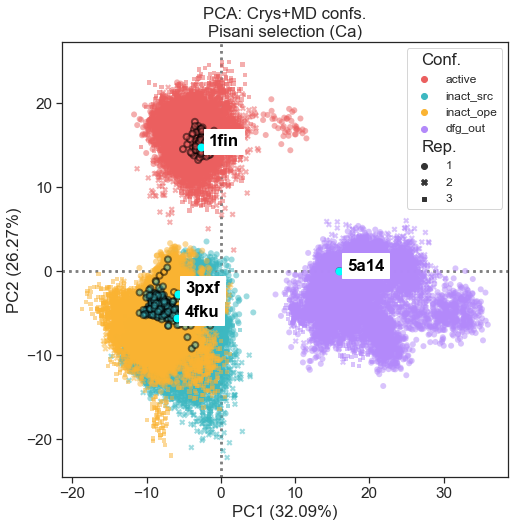

In [18]:
# Concat CRYS with MD
STRIDE = 1
MASK = mask_pisani
PLOT_TITLE = 'PCA: Crys+MD confs.\nPisani selection (Ca)'

# CRYS confs
TRAJ = crys_traj
crys_mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, 
                        ref_conf = ref_conf, 
                        stride = STRIDE)
df_crys = df_prot[['ConfTypeLabel']]\
                .loc[::STRIDE]\
                .rename(
                columns = {'ConfTypeLabel': 'Conf.'})
df_crys['source'] = 'crys' 
df_crys['Rep.'] = None
df_crys['MD-Protocol'] = None

# MD Confs
STRIDE = 1
TRAJ = md_trajs
md_mtx_coords = get_coords(traj = TRAJ, 
                           mask = MASK, 
                           ref_conf = ref_conf, 
                           stride = STRIDE)
df_md = df_md_projs\
        .loc[::STRIDE]\
        .replace(refs_conf_type_dict)[['Conf.', 'Rep.']]
df_md['source'] = 'md'

# Concatenate the matrix
mtx_coords = np.concatenate([crys_mtx_coords, 
                             md_mtx_coords], axis = 0)
# Concatenate the dataframes to label the conformations
DF_PLOT =  pd.concat([df_crys, df_md])

df_proj, exp_vars, pca = get_pca_projs(
                            mtx_coords = mtx_coords, 
                            df_labels = DF_PLOT, 
                            stride = 1)
COL_HUE = 'Conf.'
# First project the md confs
df_ = df_proj.query('source == "md"')
ax = plot_projection(df = df_, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'Rep.',
                     palette = conf_label_colors)
# Plot crys confs
df_ = df_proj.query('source == "crys"')
ax = plot_projection(df = df_, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     legend = False,
                     linewidth = 2, edgecolor = 'black',
                     palette = conf_label_colors, ax = ax)
# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax, pca, edgecolor = 'cyan',
                   xy_text_displace = (1, 0.1),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )

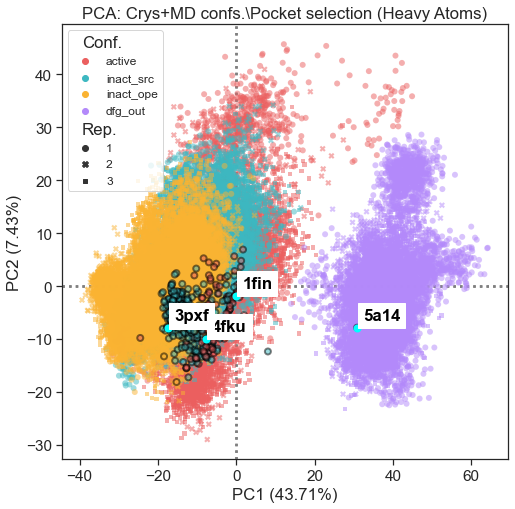

In [19]:
# Concat CRYS with MD
STRIDE = 1
MASK = mask_pkt_noHs
PLOT_TITLE = 'PCA: Crys+MD confs.\Pocket selection (Heavy Atoms)'

# CRYS confs
TRAJ = crys_traj
crys_mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, 
                        ref_conf = ref_conf, 
                        stride = STRIDE)
df_crys = df_prot[['ConfTypeLabel']]\
                .loc[::STRIDE]\
                .rename(
                columns = {'ConfTypeLabel': 'Conf.'})
df_crys['source'] = 'crys' 
df_crys['Rep.'] = None
df_crys['MD-Protocol'] = None

# MD Confs
STRIDE = 1
TRAJ = md_trajs
md_mtx_coords = get_coords(traj = TRAJ, 
                           mask = MASK, 
                           ref_conf = ref_conf, 
                           stride = STRIDE)
df_md = df_md_projs\
        .loc[::STRIDE]\
        .replace(refs_conf_type_dict)[['Conf.', 'Rep.']]
df_md['source'] = 'md'

# Concatenate the matrix
mtx_coords = np.concatenate([crys_mtx_coords, 
                             md_mtx_coords], axis = 0)
# Concatenate the dataframes to label the conformations
DF_PLOT =  pd.concat([df_crys, df_md])

df_proj, exp_vars, pca = get_pca_projs(
                            mtx_coords = mtx_coords, 
                            df_labels = DF_PLOT, 
                            stride = 1)
COL_HUE = 'Conf.'
# First project the md confs
df_ = df_proj.query('source == "md"')
ax = plot_projection(df = df_, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'Rep.',
                     palette = conf_label_colors)
# Plot crys confs
df_ = df_proj.query('source == "crys"')
ax = plot_projection(df = df_, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     legend = False,
                     linewidth = 2, edgecolor = 'black',
                     palette = conf_label_colors, ax = ax)
# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax, pca, edgecolor = 'cyan',
                   xy_text_displace = (1.5, 1.5),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )

# Projections over defined subspaces

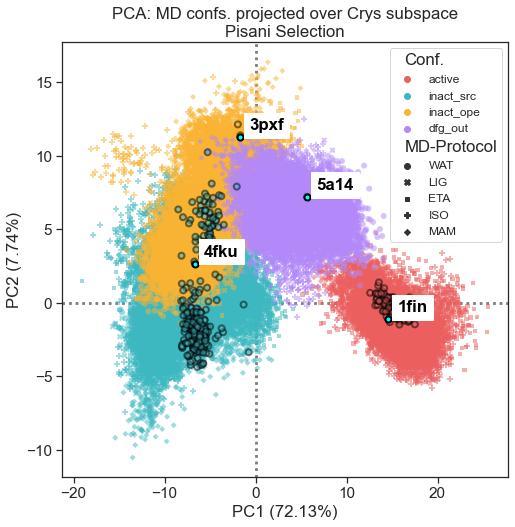

In [20]:
TRAJ    = crys_traj
MASK    = mask_pisani
STRIDE  = 1
DF_PLOT = df_prot[['PDB_ID', 'ConfTypeLabel']]
PLOT_TITLE = 'PCA: MD confs. projected over Crys subspace\n' +\
             'Pisani Selection'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)

# Project MD conformations
TRAJ = md_trajs
STRIDE = 1
md_mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
x_md, y_md = pca.transform(md_mtx_coords).T
df_md = df_md_projs\
        .loc[::STRIDE]\
        .replace(refs_conf_type_dict)[['Conf.', 'Rep.', 'MD-Protocol']]
df_md['x'] = x_md
df_md['y'] = y_md

# Plot
COL_HUE = 'Conf.'
ax = plot_projection(df = df_md, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
COL_HUE = 'ConfTypeLabel'
plot_projection(df = df_proj, color_hue = COL_HUE,  
                 plot_title = PLOT_TITLE,
                 exp_vars = exp_vars, 
                 legend = False,
                 linewidth = 2, edgecolor = 'black',
                 palette = conf_label_colors, ax = ax)

# Reference conformations
plot_initial_confs(ax, pca, 
                   xy_text_displace = (1, 0.5),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )

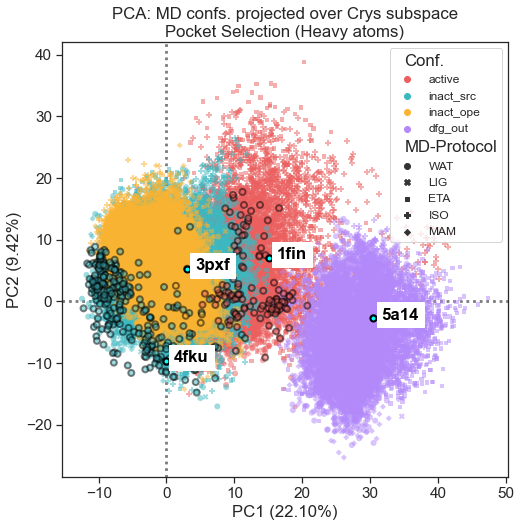

In [21]:
TRAJ    = crys_traj
MASK    = mask_pkt_noHs
STRIDE  = 1
DF_PLOT = df_prot[['PDB_ID', 'ConfTypeLabel']]
PLOT_TITLE = 'PCA: MD confs. projected over Crys subspace\n' +\
             'Pocket Selection (Heavy atoms)'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)

# Project MD conformations
TRAJ = md_trajs
STRIDE = 1
md_mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
x_md, y_md = pca.transform(md_mtx_coords).T
df_md = df_md_projs\
        .loc[::STRIDE]\
        .replace(refs_conf_type_dict)[['Conf.', 'Rep.', 'MD-Protocol']]
df_md['x'] = x_md
df_md['y'] = y_md

# Plot
COL_HUE = 'Conf.'
ax = plot_projection(df = df_md, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
COL_HUE = 'ConfTypeLabel'
plot_projection(df = df_proj, color_hue = COL_HUE,  
                 plot_title = PLOT_TITLE,
                 exp_vars = exp_vars, 
                 legend = False,
                 linewidth = 2, edgecolor = 'black',
                 palette = conf_label_colors, ax = ax)

# Reference conformations
plot_initial_confs(ax, pca, 
                   xy_text_displace = (1.2, -0.2),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )

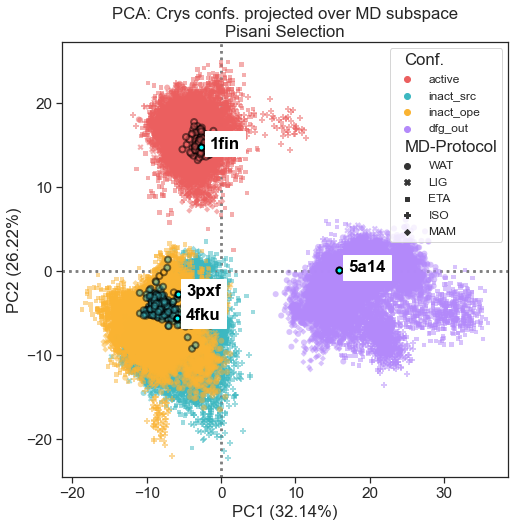

In [22]:
TRAJ    = md_trajs
MASK    = mask_pisani
STRIDE  = 1
DF_PLOT = df_md_projs.replace(refs_conf_type_dict)
PLOT_TITLE = 'PCA: Crys confs. projected over MD subspace\n' +\
             'Pisani Selection'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)

# Project MD conformations
TRAJ = crys_traj
STRIDE = 1
md_mtx_coords = get_coords(traj = TRAJ, 
                           mask = MASK, 
                           ref_conf = ref_conf, 
                           stride = STRIDE)
x_crys, y_crys = pca.transform(md_mtx_coords).T
df_crys = df_prot[['ConfTypeLabel']]\
                .loc[::STRIDE]\
                .rename(
                 columns = {'ConfTypeLabel': 'Conf.'})
df_crys['x'] = x_crys
df_crys['y'] = y_crys

# Plot
COL_HUE = 'Conf.'
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
COL_HUE = 'Conf.'
plot_projection(df = df_crys, color_hue = COL_HUE,  
                 plot_title = PLOT_TITLE,
                 exp_vars = exp_vars, 
                 legend = False,
                 linewidth = 2, edgecolor = 'black',
                 palette = conf_label_colors, ax = ax)

# Reference conformations
plot_initial_confs(ax, pca, 
                   xy_text_displace = (1.2, -0.2),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )

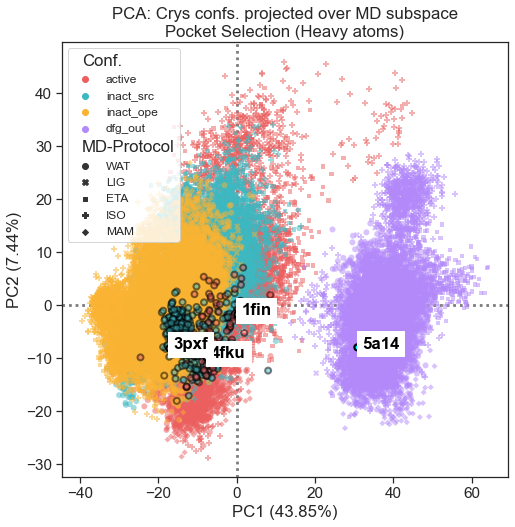

In [23]:
TRAJ    = md_trajs
MASK    = mask_pkt_noHs
STRIDE  = 1
DF_PLOT = df_md_projs.replace(refs_conf_type_dict)
PLOT_TITLE = 'PCA: Crys confs. projected over MD subspace\n' +\
             'Pocket Selection (Heavy atoms)'

mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE)

# Project MD conformations
TRAJ = crys_traj
STRIDE = 1
md_mtx_coords = get_coords(traj = TRAJ, 
                           mask = MASK, 
                           ref_conf = ref_conf, 
                           stride = STRIDE)
x_crys, y_crys = pca.transform(md_mtx_coords).T
df_crys = df_prot[['ConfTypeLabel']]\
                .loc[::STRIDE]\
                .rename(
                 columns = {'ConfTypeLabel': 'Conf.'})
df_crys['x'] = x_crys
df_crys['y'] = y_crys

# Plot
COL_HUE = 'Conf.'
ax = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
COL_HUE = 'Conf.'
plot_projection(df = df_crys, color_hue = COL_HUE,  
                 plot_title = PLOT_TITLE,
                 exp_vars = exp_vars, 
                 legend = False,
                 linewidth = 2, edgecolor = 'black',
                 palette = conf_label_colors, ax = ax)

# Reference conformations
plot_initial_confs(ax, pca, 
                   xy_text_displace = (1.2, -0.2),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )